# Tutkitaan ja esikäsitellään system_size_DC

## Pohjalle DataFrame

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import importlib.util
import sys
file_path = "../Tehtava-03/columns_file.py"; module_name = "columns_file"; spec = importlib.util.spec_from_file_location(module_name, file_path)
cf = importlib.util.module_from_spec(spec); sys.modules[module_name] = cf; spec.loader.exec_module(cf)


cols = ['total_installed_price', 'system_size_DC', 'additional_modules', 
        'installer_name', 'self_installed', 'customer_segment', 'expansion_system']
cols.extend(cf.nameplate_capacity_module)
cols.extend(cf.module_quantity)
#cols = cf.all_orig()

url = '../data/LBNL_file.csv'
df_all = pd.read_csv(url, usecols=cols, low_memory=False, na_values = '-9999')


## Keskeisten sarakkeiden perustietoja

Jos 'system_size_DC':n paikkansa pitävyyttä halutaan arvioida, tarkastetaan ensin laskentaan käytettävien sarakkeisen lukuarvoja. Suodatetaan jo aluksi pois asennukset, joissa on enemmän kuin kolmea eri paneelimallia, (df['additional_modules'] == 0).

In [2]:
df = df_all.copy()
#df = df[(df['system_size_DC'] < 1)]
df = df[(df['additional_modules'] == 0)]
#df = df[(df['additional_modules'] == 1)]
agg_func = ['size', 'count', 'min', 'max']
df.agg({
  'system_size_DC': agg_func,
  'module_quantity_1': agg_func, 'module_quantity_2': agg_func, 'module_quantity_3': agg_func,
  'nameplate_capacity_module_1': agg_func, 'nameplate_capacity_module_2': agg_func, 'nameplate_capacity_module_3': agg_func
})

,system_size_DC,module_quantity_1,module_quantity_2,module_quantity_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3
size,998855.0000,998855.0,998855.0,998855.0,998855.0,998855.00,998855.0
count,987561.0000,996212.0,13666.0,286.0,905408.0,7958.00,1175.0
min,0.0055,1.0,1.0,1.0,12.0,23.75,62.0
max,13305.6100,316514.0,12416.0,16413.0,864.0,864.00,864.0


Lukemista voi päätellä, että data ei ole täysin eheää. Pienimmät asennukset ovat jopa pienempiä kuin pienimmän yksittäisen moduulin.

## Mitkä rivit ovat laskennallisesti kunnossa?

Pyritään löytämään rivit, jotka ovat kunnossa ja erotellaan ne omaan joukkoonsa. Etsitään rivejä aluksi seuraavilla kriteereillä:

- 'system_size_DC' on määritelty
- vähintään yksi 'module_quantity' ja 'nameplate_capacity_module' pari on määritelty
- jos 'module_quantity' tai 'nameplate_capacity_module' on määritelty, myös sen pari on oltava määritelty
- 'system_size_DC' vastaa kertolaskua 'module_quantity' * 'nameplate_capacity_module' (virhemarginaali huomioitu)

In [3]:
df = df_all.copy()
df = df[(df['additional_modules'] == 0)]
cols = ['system_size_DC']
cols.extend(cf.nameplate_capacity_module)
cols.extend(cf.module_quantity)
df[cols] = df[cols].fillna(0)

# Karsinta #1
del_1 = df[(df['system_size_DC'] == 0)]
del_2 = df[(df['module_quantity_1'] > 0) & (df['nameplate_capacity_module_1'] == 0)]
del_3 = df[(df['module_quantity_1'] == 0) & (df['nameplate_capacity_module_1'] > 0)]
df = pd.concat([df, del_1, del_2, del_3])
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], keep=False, inplace=True)
df.drop('df_index', axis=1, inplace=True)

# Karsinta #2
del_1 = df[(df['module_quantity_2'] > 0) & (df['nameplate_capacity_module_2'] == 0)]
del_2 = df[(df['module_quantity_2'] == 0) & (df['nameplate_capacity_module_2'] > 0)]
df = pd.concat([df, del_1, del_2])
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], keep=False, inplace=True)
df.drop('df_index', axis=1, inplace=True)

# Karsinta #3
del_1 = df[(df['module_quantity_3'] > 0) & (df['nameplate_capacity_module_3'] == 0)]
del_2 = df[(df['module_quantity_3'] == 0) & (df['nameplate_capacity_module_3'] > 0)]
df = pd.concat([df, del_1, del_2])
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], keep=False, inplace=True)
df.drop('df_index', axis=1, inplace=True)

df[cols] = df[cols].replace(0, np.nan)
agg_func = ['size', 'count', 'min', 'max']
df_pairs = df
df_pairs.agg({
  'system_size_DC': agg_func,
  'module_quantity_1': agg_func, 'module_quantity_2': agg_func, 'module_quantity_3': agg_func,
  'nameplate_capacity_module_1': agg_func, 'nameplate_capacity_module_2': agg_func, 'nameplate_capacity_module_3': agg_func
})


,system_size_DC,module_quantity_1,module_quantity_2,module_quantity_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3
size,888636.0000,888636.0,888636.0,888636.0,888636.0,888636.0,888636.0
count,888636.0000,887974.0,5137.0,195.0,887974.0,5137.0,195.0
min,0.0066,1.0,1.0,1.0,12.0,50.0,72.0
max,13305.6100,38567.0,7440.0,3612.0,864.0,864.0,864.0


Tulokset näyttävät, että `count` lukemat täsmää, kuten suunniteltu.

## Tarkistuslaskenta

Seuraavaksi tehdään laskutoimitukset.

In [4]:
df = df_pairs.copy()
#df = df[(df['additional_modules'] == 0)]
cols = ['system_size_DC']
cols.extend(cf.nameplate_capacity_module)
cols.extend(cf.module_quantity)
# Muutos nolliksi, jotta laskenta onnistuu
df[cols] = df[cols].fillna(0)

# Laskenta
df['calc_size'] = ((df['module_quantity_1'] * df['nameplate_capacity_module_1']) +
                   (df['module_quantity_2'] * df['nameplate_capacity_module_2']) +
                   (df['module_quantity_3'] * df['nameplate_capacity_module_3']))

# Karsitaan nollat, koska niitä ei voi tarkistaa laskemalla muutenkaan
cols.append('calc_size')
df[cols] = df[cols].replace(0, np.nan)

# Muutos W -> kW
df['calc_size'] = df['calc_size'] / 1000
# Suhdeluku osoittaa hyvin onko vastaavuutta
df['ann_per_calc_ratio'] = df['system_size_DC'] / df['calc_size']
# Käänteinen suhdeluku
df['calc_per_ann_ratio'] = df['calc_size'] / df['system_size_DC']
# Kopio seuraavaan vaiheeseen
df_calc = df

# Tulokset
quantiles = np.arange(.05, 1, .05)
print("ann_per_calc_ratio quantiles:")
print(df['ann_per_calc_ratio'].quantile(quantiles))
df.agg({'ann_per_calc_ratio': ['count', 'min', 'max'], 'calc_size': ['count', 'min', 'max']})

ann_per_calc_ratio quantiles:
0.05    1.000000
0.10    1.000000
0.15    1.000000
0.20    1.000000
0.25    1.000000
0.30    1.000000
0.35    1.000000
0.40    1.000000
0.45    1.000000
0.50    1.000000
0.55    1.000000
0.60    1.000000
0.65    1.000000
0.70    1.000000
0.75    1.000000
0.80    1.000000
0.85    1.000000
0.90    1.011561
0.95    2.015160
Name: ann_per_calc_ratio, dtype: float64


,ann_per_calc_ratio,calc_size
count,887974.000000,887974.000
min,0.001092,0.024
max,4271.869474,13305.615


Laskenta viittaa siihen, että vähintään 80% lasketuista arvoista (n = 887974) vastaa sarakkeen 'system_size_DC' arvoa. Seuraavaksi muodostetaan näistä DataFrame huomioiden sallittu virhemarginaali.

In [5]:
df = df_calc.copy()
# Asetetaan sallittu virhemarginaali
margin = 0.15
df_apcr_filt = df[(df['ann_per_calc_ratio'] >= (1 - margin)) & (df['ann_per_calc_ratio'] <= (1 + margin))]
df_cpar_filt = df[(df['calc_per_ann_ratio'] >= (1 - margin)) & (df['calc_per_ann_ratio'] <= (1 + margin))]
print(df_apcr_filt.agg({'ann_per_calc_ratio': ['count', 'min', 'max'], 'calc_size': ['count', 'min', 'max']}))
print(df_cpar_filt.agg({'calc_per_ann_ratio': ['count', 'min', 'max'], 'calc_size': ['count', 'min', 'max']}))

       ann_per_calc_ratio   calc_size
count       808129.000000  808129.000
min              0.850488       0.068
max              1.149863   13305.615
       calc_per_ann_ratio   calc_size
count       808686.000000  808686.000
min              0.850013       0.068
max              1.150000   13305.615


## Lisää tuloksia

Tehdään sama tulostus kuin alussa datalle, joka on hyväksi todettu. Huomataan ainakin, että pienimmäksi 'system_size_DC':ksi tulee 0.068 kW, joka on jo vähän uskottavampi kuin 0.0055 kW.

In [6]:
df = df_apcr_filt.copy()
df['price_per_kW'] = df['total_installed_price'] / df['system_size_DC']
df = df[(df['price_per_kW'] > 0)]
print("Ilmoitettu / laskettu, 'price per' kW > 0, virhemarginaali:", str(100*margin), "%")
display(df.agg({
  'system_size_DC': agg_func,
  'module_quantity_1': agg_func, 'module_quantity_2': agg_func, 'module_quantity_3': agg_func,
  'nameplate_capacity_module_1': agg_func, 'nameplate_capacity_module_2': agg_func, 'nameplate_capacity_module_3': agg_func
}))
print("Laskettu / ilmoitettu, 'price per' kW > 0, virhemarginaali:", str(100*margin), "%")
df = df_cpar_filt.copy()
df['price_per_kW'] = df['total_installed_price'] / df['system_size_DC']
df = df[(df['price_per_kW'] > 0)]
display(df.agg({
  'system_size_DC': agg_func,
  'module_quantity_1': agg_func, 'module_quantity_2': agg_func, 'module_quantity_3': agg_func,
  'nameplate_capacity_module_1': agg_func, 'nameplate_capacity_module_2': agg_func, 'nameplate_capacity_module_3': agg_func
}))

Ilmoitettu / laskettu, 'price per' kW > 0, virhemarginaali: 15.0 %


,system_size_DC,module_quantity_1,module_quantity_2,module_quantity_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3
size,686467.0000,686467.0,686467.0,686467.0,686467.0,686467.0,686467.0
count,686467.0000,686467.0,2680.0,112.0,686467.0,2680.0,112.0
min,0.2400,1.0,1.0,1.0,12.0,50.0,72.0
max,7586.5625,19206.0,6192.0,3612.0,864.0,864.0,864.0


Laskettu / ilmoitettu, 'price per' kW > 0, virhemarginaali: 15.0 %


,system_size_DC,module_quantity_1,module_quantity_2,module_quantity_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3
size,687089.0000,687089.0,687089.0,687089.0,687089.0,687089.0,687089.0
count,687089.0000,687089.0,2663.0,107.0,687089.0,2663.0,107.0
min,0.2400,1.0,1.0,1.0,12.0,50.0,72.0
max,7586.5625,19206.0,6192.0,3612.0,864.0,864.0,864.0


In [7]:
df = df_cpar_filt.copy()
display(df.groupby(['customer_segment']).agg({'system_size_DC': agg_func}))
#df = df[(df['system_size_DC'] == 0.068)]
#df

system_size_DC                         
                           size   count    min       max
customer_segment                                        
COM                       15477   15477  0.230  13305.61
GOV                        2665    2665  1.380   4593.60
NON-PROFIT                 1330    1330  1.290   1149.54
RES                      788327  788327  0.068   1106.56
SCHOOL                      887     887  2.600   4445.28

## Ongelmalliset 'system_size_DC' arvot

Käsitellään ensimmäisenä arvot, jotka karsittiin rajaamalla virhemarginaalilla. Piirretään kuvaajat suhdelukujen jakaumista.

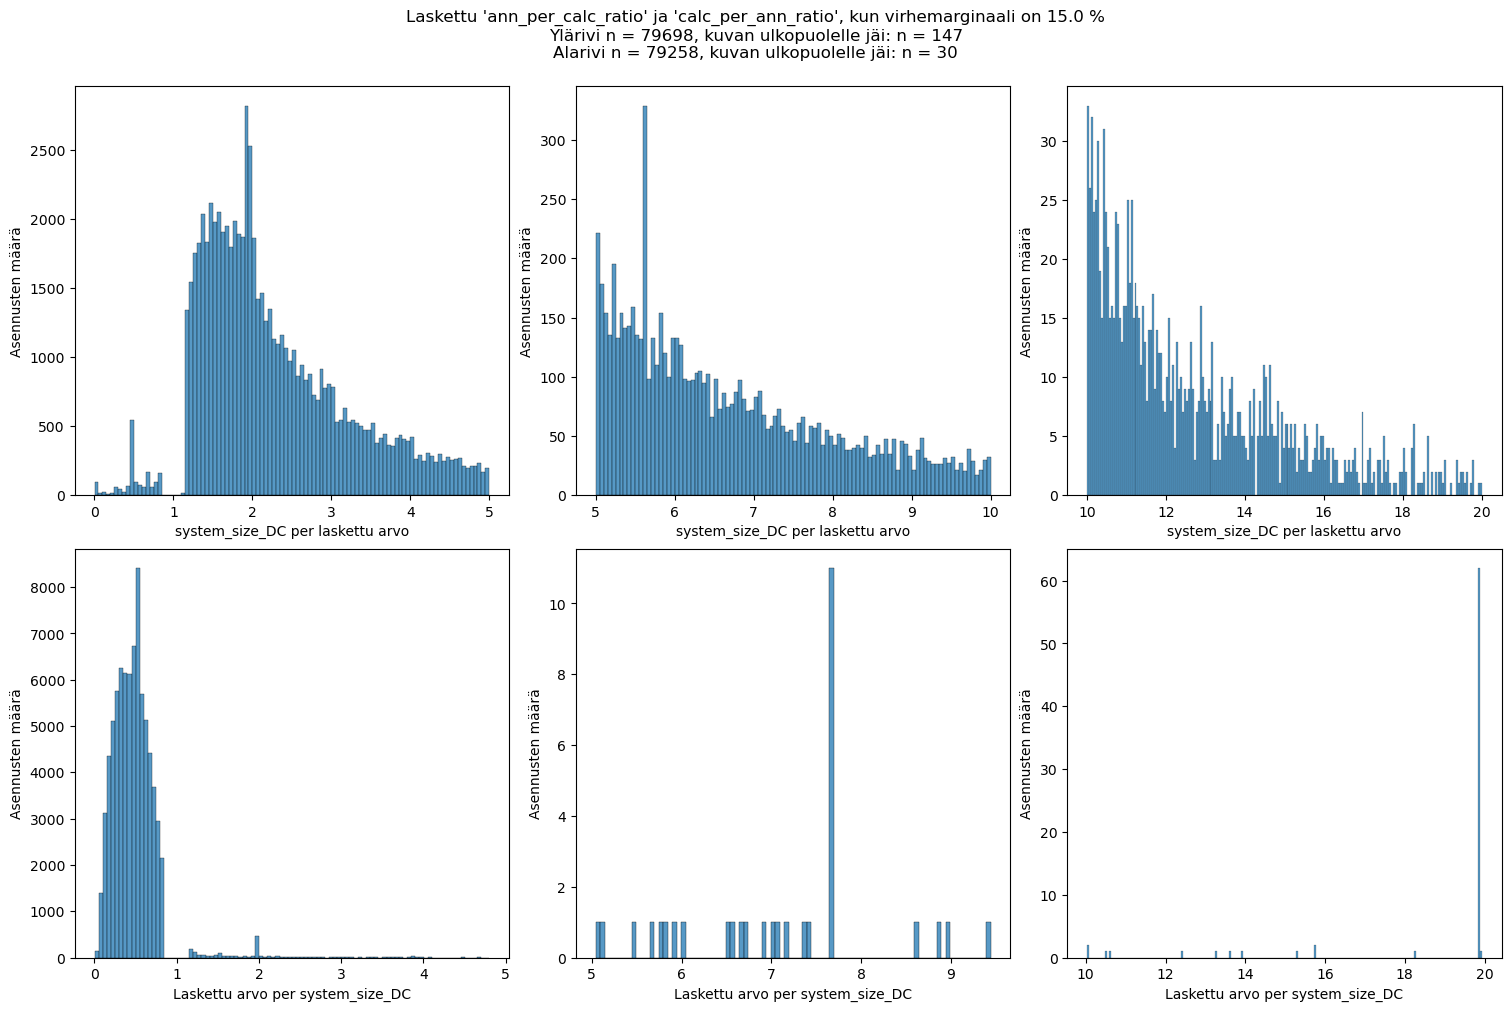

In [8]:
binwidth = 0.05
max_1 = 5
max_2 = 10
max_3 = 20

# Yläriviin
df = df_calc.copy()
df = pd.concat([df, df_apcr_filt])
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], keep=False, inplace=True)
df.drop('df_index', axis=1, inplace=True)
count_1 = df['ann_per_calc_ratio'].count()

# Datan rajaus eri kuviin
df_1 = df[(df['ann_per_calc_ratio'] < max_1)]

df_2 = df[(df['ann_per_calc_ratio'] < max_2)]
df_2 = df_2[(df_2['ann_per_calc_ratio'] >= (max_1))]

df_3 = df[(df['ann_per_calc_ratio'] < max_3)]
count_2 = df_3['ann_per_calc_ratio'].count()
df_3 = df_3[(df_3['ann_per_calc_ratio'] >= (max_2))]

# Alariviin
df = df_calc.copy()
df = pd.concat([df, df_cpar_filt])
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], keep=False, inplace=True)
df.drop('df_index', axis=1, inplace=True)
count_3 = df['calc_per_ann_ratio'].count()

# Datan rajaus eri kuviin
df_4 = df[(df['calc_per_ann_ratio'] < max_1)]

df_5 = df[(df['calc_per_ann_ratio'] < max_2)]
df_5 = df_5[(df_5['calc_per_ann_ratio'] >= (max_1))]

df_6 = df[(df['calc_per_ann_ratio'] < max_3)]
count_4 = df_6['calc_per_ann_ratio'].count()
df_6 = df_6[(df_6['calc_per_ann_ratio'] >= (max_2))]

# Piirto
size_mult = 5
fig_rows = 2
fig_cols = 3
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='ann_per_calc_ratio', ax=axs[0, 0], binwidth=binwidth)
sns.histplot(data=df_2, x='ann_per_calc_ratio', ax=axs[0, 1], binwidth=binwidth)
sns.histplot(data=df_3, x='ann_per_calc_ratio', ax=axs[0, 2], binwidth=binwidth)
sns.histplot(data=df_4, x='calc_per_ann_ratio', ax=axs[1, 0], binwidth=binwidth)
sns.histplot(data=df_5, x='calc_per_ann_ratio', ax=axs[1, 1], binwidth=binwidth)
sns.histplot(data=df_6, x='calc_per_ann_ratio', ax=axs[1, 2], binwidth=binwidth)
for i in range(fig_rows):
  if i == 0:
    xlabel = 'system_size_DC per laskettu arvo'
  if i == 1:
    xlabel = 'Laskettu arvo per system_size_DC'
  for j in range(fig_cols):
    axs[i, j].set_xlabel(xlabel)
    axs[i, j].set_ylabel('Asennusten määrä')

title = f'''Laskettu 'ann_per_calc_ratio' ja 'calc_per_ann_ratio', kun virhemarginaali on {str(100*margin)} %
Ylärivi n = {str(count_2)}, kuvan ulkopuolelle jäi: n = {str(count_1 - count_2)}
Alarivi n = {str(count_4)}, kuvan ulkopuolelle jäi: n = {str(count_3 - count_4)}
'''

fig.suptitle(title)
plt.show()

Kuvaajista on helppo päätellä, että valtaosa lasketuista arvoista on pienempi kuin datassa ilmoitettu 'system_size_DC'.

### Lyhyt katsaus ongelmallisiin arvoihin

Luodaan myös `df_error`, jossa on kaikki 'system_size_DC':n arvot, joita ei voitu laskennassa osoittaa luotettaviksi.

In [9]:
df = df_all.copy()
df = pd.concat([df, df_apcr_filt])
df['df_index'] = df.index
df.drop_duplicates(subset=['df_index'], keep=False, inplace=True)
df.drop('df_index', axis=1, inplace=True)
#quantiles = np.arange(.05, 1, .05)
#print("system_size_DC quantiles:")
#print(df['system_size_DC'].quantile(quantiles))
df_error = df
df_error.agg({
  'system_size_DC': agg_func,
  'module_quantity_1': agg_func, 'module_quantity_2': agg_func, 'module_quantity_3': agg_func,
  'nameplate_capacity_module_1': agg_func, 'nameplate_capacity_module_2': agg_func, 'nameplate_capacity_module_3': agg_func
})

,system_size_DC,module_quantity_1,module_quantity_2,module_quantity_3,nameplate_capacity_module_1,nameplate_capacity_module_2,nameplate_capacity_module_3
size,191871.000000,191871.0,191871.0,191871.0,191871.0,191871.00,191871.0
count,180563.000000,188199.0,9538.0,200.0,98078.0,3821.00,1107.0
min,0.005500,1.0,1.0,1.0,12.0,23.75,62.0
max,5795.426571,316514.0,12416.0,16413.0,576.0,435.00,435.0


In [10]:
df_error.groupby(['customer_segment']).agg({'system_size_DC': agg_func})

system_size_DC                               
                           size   count       min          max
customer_segment                                              
COM                        4216    3903  0.026400  5795.426571
GOV                         465     322  1.190204  4725.840000
NON-PROFIT                  216     216  0.035200  1219.539196
NON-RES                      66      65  0.875000   880.000000
RES                      186538  175743  0.005500  1100.718000
SCHOOL                      370     314  2.970000  1626.363184

## Vertaillaan suodatusta ja korvausta

Piirretään kuvaajia koko datasta. Tutkitaan suodatuksen ja korvauksen vaikutusta hintatehosuhteeseen. Suodatettu vastaa siis laskennalla tarkistettuja arvoja ja korvaus tarkoittaa 'system_size_DC':n arvon korvaamista, jos asialliset moduulin määrä- ja tehotiedot löytyvät. Korvauksessa käytetään käytännössä vain laskennalla saatuja arvoja, joten 'system_size_DC':n arvoa ei käytetä, jos sitä ei ole voitu laskea.

Lisäksi vertailussa on mukana täysin suodattamaton data, jossa ehtona on vain se, että sekä 'total_installed_price' että 'system_size_DC' on määritelty datassa.

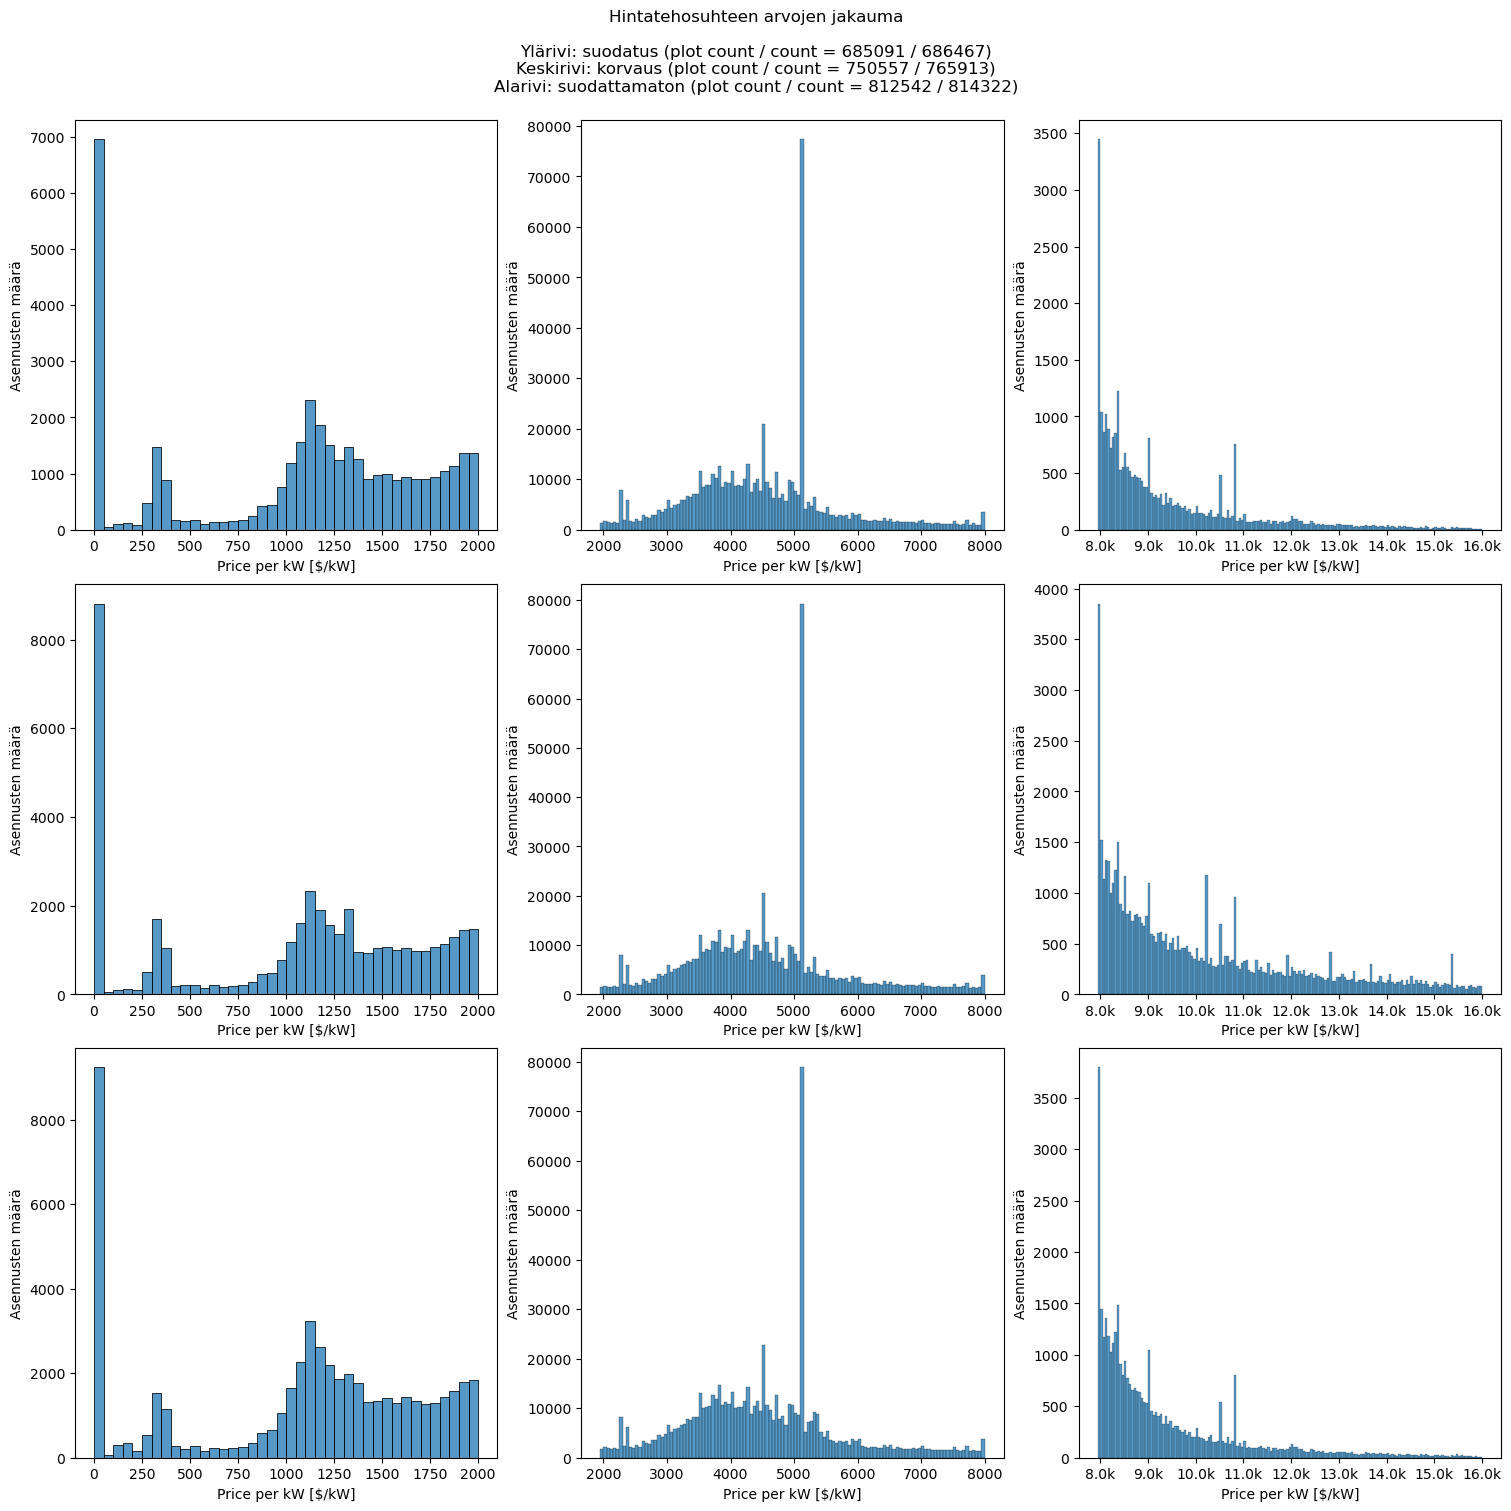

In [11]:
# FormatterFunc
def no_mult(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.0f}'.format(x)

def kilo(x, pos):
    """The two arguments are the value and tick position."""
    return '{:1.1f}k'.format(x*1e-3)

binwidth = 50
max_1 = 2000
max_2 = 8000
max_3 = 16000

# Ylärivi, tiukka suodatus + virhemarginaali
df = df_apcr_filt.copy()
df['price_per_kW'] = df['total_installed_price'] / df['system_size_DC']
count_1 = df['price_per_kW'].count()

# Datan rajaus eri kuviin
df_1 = df[(df['price_per_kW'] < max_1)]

df_2 = df[(df['price_per_kW'] < max_2)]
df_2 = df_2[(df_2['price_per_kW'] >= (max_1 - binwidth))]

df_3 = df[(df['price_per_kW'] < max_3)]
plot_count_1 = df_3['price_per_kW'].count()
df_3 = df_3[(df_3['price_per_kW'] >= (max_2 - binwidth))]

# Keskirivi, 'system_size_DC' korvattu 'calc_size' 'price_per_kW' laskennassa
df = df_calc.copy()
df['price_per_kW'] = df['total_installed_price'] / df['calc_size']
count_2 = df['price_per_kW'].count()

# Datan rajaus eri kuviin
df_4 = df[(df['price_per_kW'] < max_1)]

df_5 = df[(df['price_per_kW'] < max_2)]
df_5 = df_5[(df_5['price_per_kW'] >= (max_1 - binwidth))]

df_6 = df[(df['price_per_kW'] < max_3)]
plot_count_2 = df_6['price_per_kW'].count()
df_6 = df_6[(df_6['price_per_kW'] >= (max_2 - binwidth))]

# Alarivi, suodattamaton
df = df_all.copy()
df['price_per_kW'] = df['total_installed_price'] / df['system_size_DC']
count_3 = df['price_per_kW'].count()

# Datan rajaus eri kuviin
df_7 = df[(df['price_per_kW'] < max_1)]

df_8 = df[(df['price_per_kW'] < max_2)]
df_8 = df_8[(df_8['price_per_kW'] >= (max_1 - binwidth))]

df_9 = df[(df['price_per_kW'] < max_3)]
plot_count_3 = df_9['price_per_kW'].count()
df_9 = df_9[(df_9['price_per_kW'] >= (max_2 - binwidth))]

# Piirto
size_mult = 5
fig_rows = 3
fig_cols = 3
fig, axs = plt.subplots(fig_rows, fig_cols, layout="constrained", figsize=((fig_cols*size_mult),(fig_rows*size_mult)))

sns.histplot(data=df_1, x='price_per_kW', ax=axs[0, 0], binwidth=binwidth)
sns.histplot(data=df_2, x='price_per_kW', ax=axs[0, 1], binwidth=binwidth)
sns.histplot(data=df_3, x='price_per_kW', ax=axs[0, 2], binwidth=binwidth)
sns.histplot(data=df_4, x='price_per_kW', ax=axs[1, 0], binwidth=binwidth)
sns.histplot(data=df_5, x='price_per_kW', ax=axs[1, 1], binwidth=binwidth)
sns.histplot(data=df_6, x='price_per_kW', ax=axs[1, 2], binwidth=binwidth)
sns.histplot(data=df_7, x='price_per_kW', ax=axs[2, 0], binwidth=binwidth)
sns.histplot(data=df_8, x='price_per_kW', ax=axs[2, 1], binwidth=binwidth)
sns.histplot(data=df_9, x='price_per_kW', ax=axs[2, 2], binwidth=binwidth)
for i in range(fig_rows):
  for j in range(fig_cols):
    axs[i, j].set_xlabel('Price per kW [$/kW]')
    axs[i, j].set_ylabel('Asennusten määrä')
  axs[i, 0].xaxis.set_major_formatter(no_mult)
  axs[i, 1].xaxis.set_major_formatter(no_mult)
  axs[i, 2].xaxis.set_major_formatter(kilo)

title = f'''Hintatehosuhteen arvojen jakauma

Ylärivi: suodatus (plot count / count = {str(plot_count_1)} / {str(count_1)})
Keskirivi: korvaus (plot count / count = {str(plot_count_2)} / {str(count_2)})
Alarivi: suodattamaton (plot count / count = {str(plot_count_3)} / {str(count_3)})
'''

fig.suptitle(title)
plt.show()


Kuvaajat näyttävät pitkälti samoilta. Suurimmat erot löytyvät korvauksen käytöstä. Keskirivin kuvaajissa näkyy enemmän pieniä piikkejä oikeanpuolimmaisessa kuvassa. Lisäksi korvausta käytettäessä korkeat hintatehosuhteen arvot ovat tasaisesti suurempia. Tämä näkyy myös kuvaajan ulkopuolelle jääneiden asennusten määrässä. Tulos on yhteydessä aikaisempaan havaintoon siitä, että lasketut arvot, jotka eivät vastaa ilmoitettua arvoa, ovat enimmäkseen ilmoitettua arvoa pienempiä, jolloin hintatehosuhde nousee.

Edellä mainituista syystä johtuen korvauksen käyttö on ilmeisesti enemmän haitallista kuin hyödyllistä.

## Loppupäätelmä

Voi olla hyvä idea lisätä esikäsittelijään mahdollisuus suodattaa data, kun halutaan karsia virheitä. Ne asennukset, joissa laskettu arvo ei ole riittävän lähellä ilmoitettua arvoa on parempi jättää ennalleen tai karsia kokonaan pois. Eli käytännössä korvaus vaikuttaa huonosti perusteltavissa olevalta vaihtoehdolta.

On hyvä muistaa yksi suodatuksen ongelma. Laskentaa ei ole tehty, jos asennuksessa on enemmän kuin kolmea eri paneelia käytössä, joka mahdollisesti turhaan karsii osan asennuksista pois. Alla katsaus näihin asennuksiin.

In [12]:
df = df_all.copy()
df['additional_modules'] = df['additional_modules'].replace(np.nan, -1)
df = df[(df['additional_modules'] == -1)]
print("additional_modules == NaN")
display(df.groupby(['customer_segment']).agg({'system_size_DC': ['size', 'count', 'min', 'median', 'mean', 'max']}))
df = df_all.copy()
df = df[(df['additional_modules'] == 1)]
print("additional_modules == 1")
display(df.groupby(['customer_segment']).agg({'system_size_DC': ['size', 'count', 'min', 'median', 'mean', 'max']}))

additional_modules == NaN


system_size_DC                                         
                           size count     min  median       mean     max
customer_segment                                                        
COM                          11    11   2.700  13.800  14.746364   25.00
GOV                           1     1   6.800   6.800   6.800000    6.80
NON-PROFIT                    1     1  16.770  16.770  16.770000   16.77
NON-RES                      66    65   0.875  17.010  69.033785  880.00
RES                         950   950   0.340   4.588   5.182565   36.60

additional_modules == 1


system_size_DC                                             \
                           size count        min       median         mean   
customer_segment                                                             
COM                          31    31     2.0000   105.417200   282.598413   
GOV                           6     5   151.2380   660.990000   638.215200   
NON-PROFIT                    1     1  1174.0800  1174.080000  1174.080000   
RES                          78    66     0.0957     4.341876     5.979467   

                            
                       max  
customer_segment            
COM               1922.947  
GOV               1112.388  
NON-PROFIT        1174.080  
RES                 36.230